I used a CatBoostClassifier without tuning. <b>
    

| class        	| precision 	| recall 	| f1-score 	| support 	|
|--------------	|-----------	|--------	|----------	|---------	|
| 0            	| 0.91      	| 0.94   	| 0.92     	| 369      	|
| 1            	| 0.92      	| 0.87   	| 0.89     	| 276     	|
| accuracy     	|           	|        	| 0.91     	| 645     	|
| macro avg    	| 0.91      	| 0.90   	| 0.91     	| 645     	|
| weighted avg 	| 0.91      	| 0.91   	| 0.91     	| 645     	|



In [1]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report,ConfusionMatrixDisplay,r2_score,mean_squared_error

from catboost import CatBoostClassifier

# <span style="color:#e74c3c;"> Reading </span> Data


In [2]:
data = pd.read_excel('/kaggle/input/pistachio-dataset/Pistachio_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.xlsx')
data.head()

,Area,Perimeter,Major_Axis,Minor_Axis,Eccentricity,Eqdiasq,Solidity,Convex_Area,Extent,Aspect_Ratio,...,StdDev_RR,StdDev_RG,StdDev_RB,Skew_RR,Skew_RG,Skew_RB,Kurtosis_RR,Kurtosis_RG,Kurtosis_RB,Class
0,63391,1568.405,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,...,17.7206,19.6024,21.1342,0.4581,0.6635,0.7591,2.9692,3.0576,2.9542,Kirmizi_Pistachio
1,68358,1942.187,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,...,26.7061,27.2112,25.1035,-0.3847,-0.2713,-0.2927,1.9807,2.1006,2.2152,Kirmizi_Pistachio
2,73589,1246.538,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,...,19.0129,20.0703,20.7006,-0.6014,-0.4500,0.2998,3.5420,3.6856,4.1012,Kirmizi_Pistachio
3,71106,1445.261,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,...,18.1773,18.7152,29.7883,-0.6943,-0.6278,-0.7798,2.8776,2.8748,2.8953,Kirmizi_Pistachio
4,80087,1251.524,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,...,23.4298,24.0878,23.1157,-0.9287,-0.8134,-0.4970,2.9915,2.8813,2.7362,Kirmizi_Pistachio


In [3]:
data['Class'].value_counts()

Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: Class, dtype: int64

In [4]:
# total null elements

data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [5]:
# creating train data and target

y = data.pop('Class')
X = data

LB = LabelBinarizer()
y = LB.fit_transform(y)

In [6]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,2148.0,79950.655493,13121.737799,29808.0000,71936.750000,79905.50000,89030.500000,124008.0000
Perimeter,2148.0,1425.971751,375.565503,858.3630,1170.996250,1262.78550,1607.906250,2755.0491
Major_Axis,2148.0,446.248968,32.445304,320.3445,426.508750,448.57475,468.509400,541.9661
Minor_Axis,2148.0,238.311842,30.310695,133.5096,217.875825,236.41635,257.760150,383.0461
Eccentricity,2148.0,0.840219,0.048759,0.5049,0.817500,0.84965,0.875200,0.9460
Eqdiasq,2148.0,317.919173,26.908600,194.8146,302.642850,318.96530,336.685525,397.3561
Solidity,2148.0,0.940093,0.050452,0.5880,0.919850,0.95415,0.976925,0.9951
Convex_Area,2148.0,85015.839851,13154.919327,37935.0000,76467.000000,85075.50000,93893.500000,132478.0000
Extent,2148.0,0.716067,0.052532,0.4272,0.687000,0.72650,0.753600,0.8204
Aspect_Ratio,2148.0,1.898154,0.240100,1.1585,1.736375,1.89625,2.067025,3.0858


# <span style="color:#e74c3c;"> Feature </span> Importance


In [7]:
point_biserial_coefs = []

for i in range(X.shape[1]):
    coef = stats.pointbiserialr(X.iloc[:,i], y)[0]
    point_biserial_coefs.append(coef[0])
    
    
mutual_inf = mutual_info_classif(X,y)


feature_importance = pd.DataFrame({'Mutual Inf':mutual_inf, 'Point-BiSerial':point_biserial_coefs}, index = X.columns )
feature_importance.sort_values(by = 'Point-BiSerial', ascending = False)

,Mutual Inf,Point-BiSerial
Minor_Axis,0.321084,0.668126
Shapefactor_3,0.258869,0.626304
Compactness,0.259170,0.624939
Area,0.233773,0.589226
Convex_Area,0.226870,0.584618
Eqdiasq,0.234420,0.577300
Mean_RR,0.057107,0.332455
Mean_RG,0.064860,0.292409
Mean_RB,0.043615,0.229117
Kurtosis_RR,0.026147,0.155714


In [8]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 10)

# <span style="color:#e74c3c;"> CatBoost </span> Classifier


In [9]:
model = CatBoostClassifier()

model.fit(X_train, y_train, verbose =200)

Learning rate set to 0.01226
0:	learn: 0.6804579	total: 66.2ms	remaining: 1m 6s
200:	learn: 0.1984437	total: 1.06s	remaining: 4.21s
400:	learn: 0.1368889	total: 2.13s	remaining: 3.19s
600:	learn: 0.0992548	total: 3.12s	remaining: 2.07s
800:	learn: 0.0735327	total: 4.1s	remaining: 1.02s
999:	learn: 0.0549636	total: 5.08s	remaining: 0us


# <span style="color:#e74c3c;"> Results </span> 


In [10]:
pred = model.predict(X_test)

clf_report = classification_report(y_test, pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       369
           1       0.92      0.87      0.89       276

    accuracy                           0.91       645
   macro avg       0.91      0.90      0.91       645
weighted avg       0.91      0.91      0.91       645



In [11]:
roc_auc_scr = roc_auc_score(y_test, pred)
mse = mean_squared_error(y_test, pred)

print('Mean Squared Error :{0:.5f}'.format(mse))
print('ROC AUC Test Score: {0:.3f}'.format(roc_auc_scr) )

Mean Squared Error :0.08992
ROC AUC Test Score: 0.905


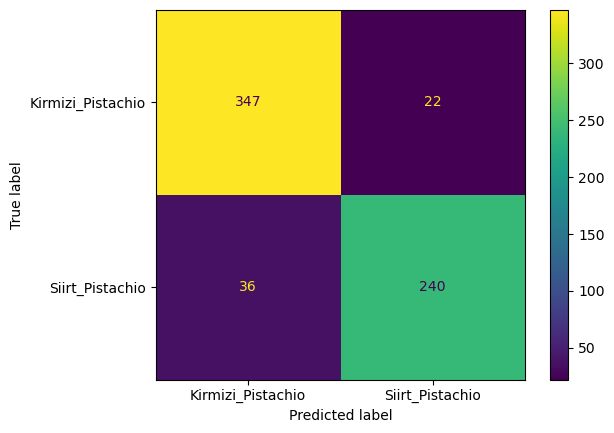

In [12]:
cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(cm, display_labels=LB.classes_ )
disp.plot()

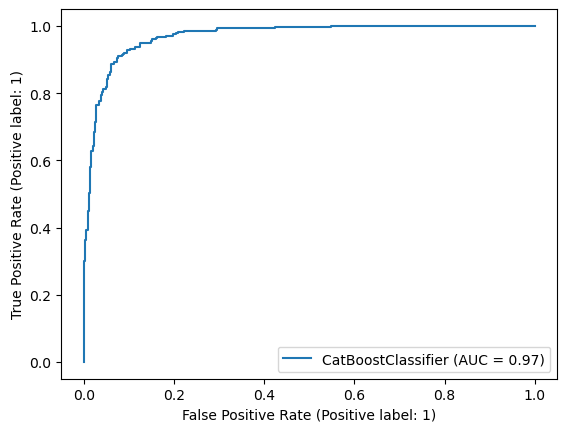

In [13]:
RocCurveDisplay.from_estimator(model, X_test, y_test)